In [46]:
import ee
ee.Authenticate()

True

In [47]:
from datetime import datetime
import pandas as pd

def ee_millis_to_date(millis):
    return datetime.utcfromtimestamp(millis / 1000).strftime("%Y-%m-%d")


In [50]:
import os
import requests

ee.Initialize()

# =================================================
# USER INPUT
# =================================================
AOI = ee.Geometry.Polygon(
    [[
            [
              81.3330698239775,
              16.453278012725704
            ],
            [
              81.33696839766054,
              16.439553952271268
            ],
            [
              81.37497949105699,
              16.450601262906417
            ],
            [
              81.36665072001,
              16.465301707731314
            ],
            [
              81.3330698239775,
              16.453278012725704
            ]
          ]]
)

# =================================================
# LOCAL OUTPUT FOLDER (JUST LIKE COASTAL PROJECT)
# =================================================
local_folder = "NDVI_images"
os.makedirs(local_folder, exist_ok=True)

# =================================================
# RABI SEASON WINDOW (BEST NDVI QUALITY)
# =================================================
START_DATE = "2024-01-01"
END_DATE   = "2024-05-15"
WINDOW_DAYS = 14

# =================================================
# GENERATE DATE WINDOWS
# =================================================
def generate_date_windows(start_date, end_date, step_days):
    start = ee.Date(start_date)
    end = ee.Date(end_date)

    offsets = ee.List.sequence(
        0,
        end.difference(start, "day").subtract(step_days),
        step_days
    )

    return offsets.map(
        lambda d: ee.Dictionary({
            "start": start.advance(d, "day"),
            "end": start.advance(d, "day").advance(step_days, "day")
        })
    )

date_windows = generate_date_windows(
    START_DATE, END_DATE, WINDOW_DAYS
).getInfo()   # client-side loop (your style)

# =================================================
# NDVI COMPOSITE FUNCTION
# =================================================
def get_indices_composite(start_date, end_date):
    def add_indices(img):
        # NDVI
        ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")

        # EVI
        evi = img.expression(
            "2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))",
            {
                "NIR": img.select("B8"),
                "RED": img.select("B4"),
                "BLUE": img.select("B2")
            }
        ).rename("EVI")

        # Red-Edge NDVI (using B5)
        rendvi = img.normalizedDifference(["B8", "B5"]).rename("RENDVI")

        return img.addBands([ndvi, evi, rendvi])

    collection = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(AOI)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 35))
        .map(add_indices)
    )

    composite = ee.Image(
        ee.Algorithms.If(
            collection.size().gt(0),
            collection.qualityMosaic("NDVI"),
            ee.Image.constant([0, 0, 0]).rename(["NDVI", "EVI", "RENDVI"])
        )
    )

    return composite.select(["NDVI", "EVI", "RENDVI"]).clip(AOI)




# =================================================
# DOWNLOAD NDVI IMAGES LOCALLY (KEY PART)
# =================================================
for w in date_windows:
    start = ee_millis_to_date(w["start"]["value"])
    end   = ee_millis_to_date(w["end"]["value"])

    print(f"Processing window: {start} to {end}")

    # 🔁 CHANGED: use new composite function
    indices = get_indices_composite(start, end)

    url = indices.getDownloadURL({
        "scale": 10,
        "region": AOI,
        "format": "GeoTIFF"
    })

    # 🔁 CHANGED: filename reflects multiple indices
    local_path = os.path.join(
        local_folder,
        f"INDICES_{start}_{end}.tif"
    )

    r = requests.get(url)
    with open(local_path, "wb") as f:
        f.write(r.content)

    print(f"Downloaded NDVI_{start}_{end}.tif")



C:\Users\saina\AppData\Local\Temp\ipykernel_29520\3722417796.py:5: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(millis / 1000).strftime("%Y-%m-%d")


Processing window: 2024-01-01 to 2024-01-15
Downloaded NDVI_2024-01-01_2024-01-15.tif
Processing window: 2024-01-15 to 2024-01-29
Downloaded NDVI_2024-01-15_2024-01-29.tif
Processing window: 2024-01-29 to 2024-02-12
Downloaded NDVI_2024-01-29_2024-02-12.tif
Processing window: 2024-02-12 to 2024-02-26
Downloaded NDVI_2024-02-12_2024-02-26.tif
Processing window: 2024-02-26 to 2024-03-11
Downloaded NDVI_2024-02-26_2024-03-11.tif
Processing window: 2024-03-11 to 2024-03-25
Downloaded NDVI_2024-03-11_2024-03-25.tif
Processing window: 2024-03-25 to 2024-04-08
Downloaded NDVI_2024-03-25_2024-04-08.tif
Processing window: 2024-04-08 to 2024-04-22
Downloaded NDVI_2024-04-08_2024-04-22.tif
Processing window: 2024-04-22 to 2024-05-06
Downloaded NDVI_2024-04-22_2024-05-06.tif


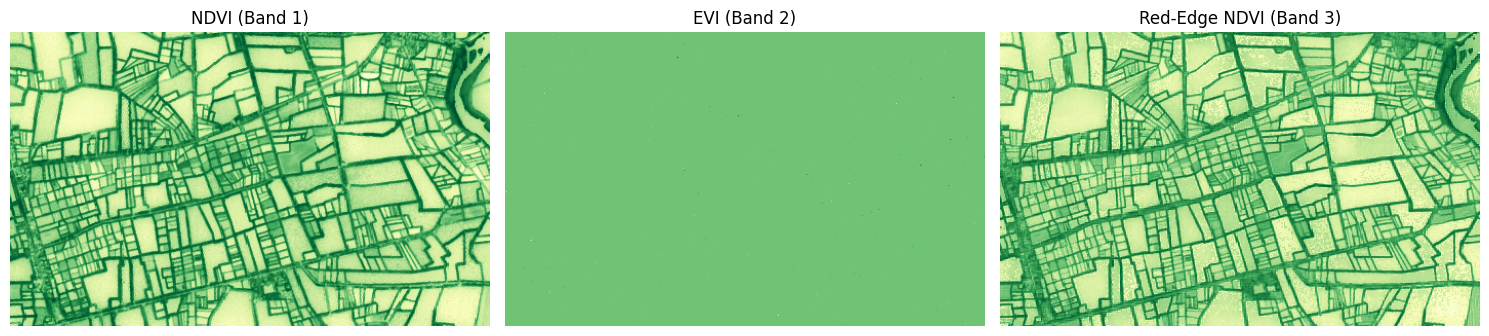

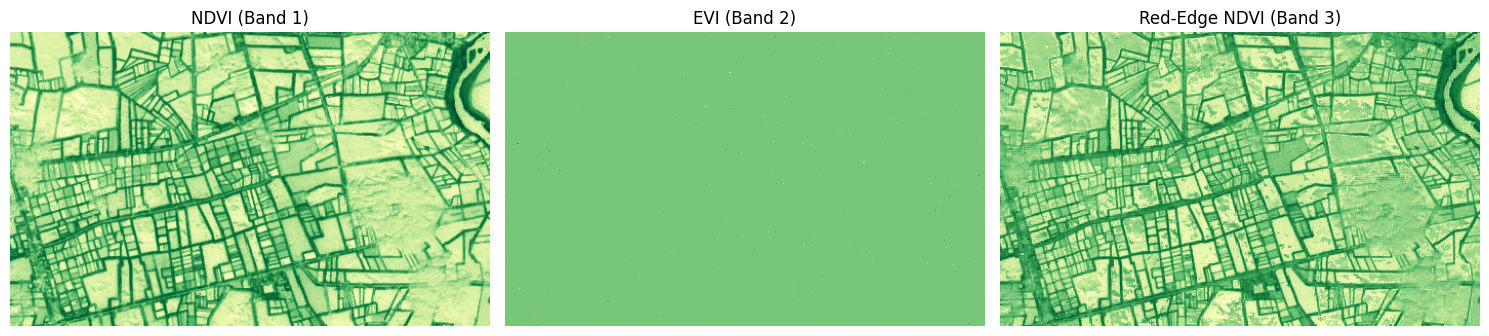

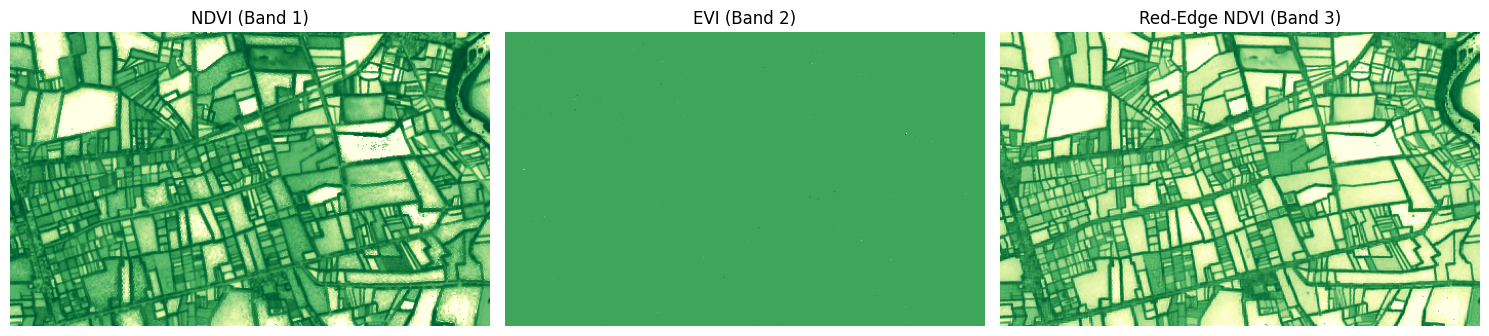

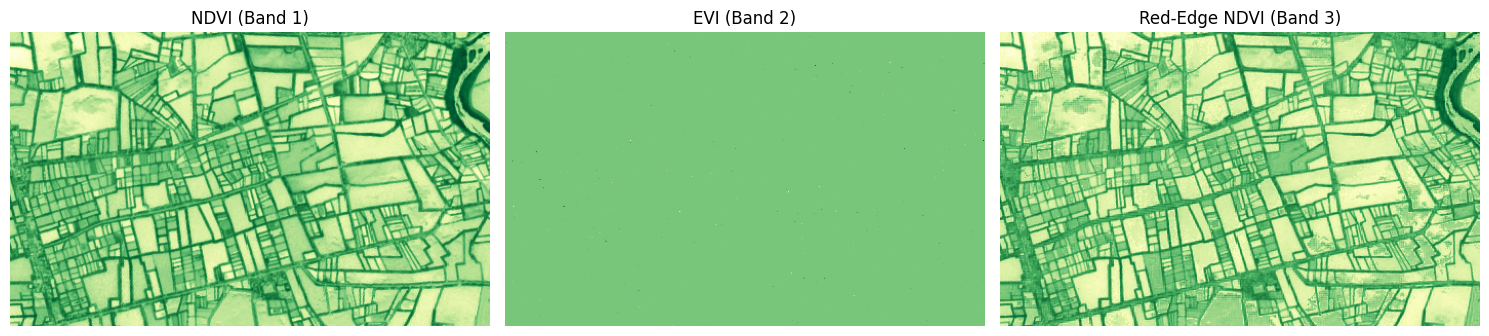

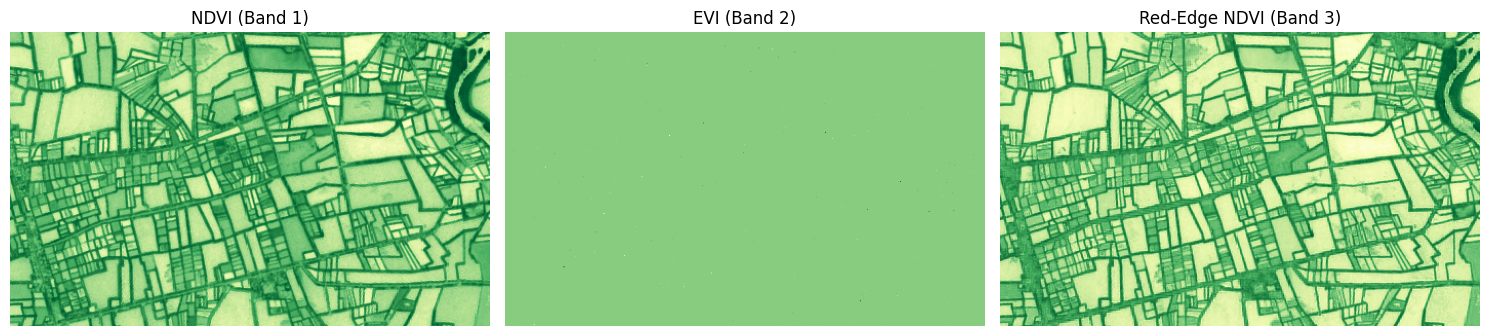

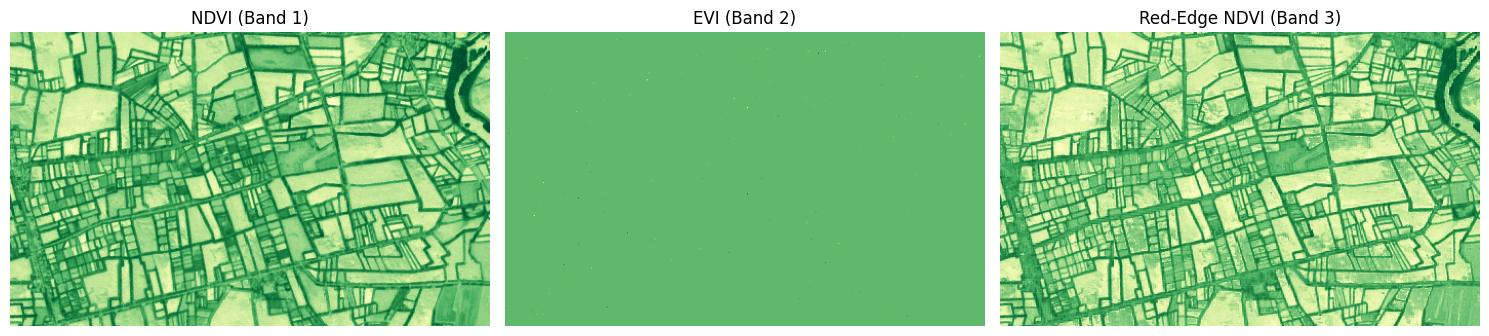

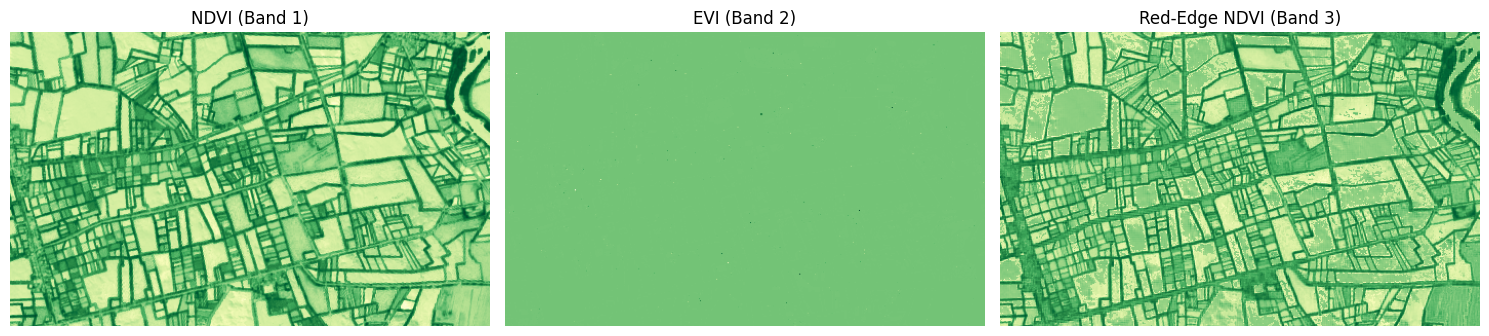

In [51]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

for f in valid_images:
    with rasterio.open(f) as src:
        ndvi   = src.read(1)
        evi    = src.read(2)
        rendvi = src.read(3)
    
        ndvi   = np.where(ndvi == src.nodata, np.nan, ndvi)
        evi    = np.where(evi == src.nodata, np.nan, evi)
        rendvi = np.where(rendvi == src.nodata, np.nan, rendvi)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ndvi, cmap="YlGn")
    axes[0].set_title("NDVI (Band 1)")
    axes[0].axis("off")
    
    axes[1].imshow(evi, cmap="YlGn")
    axes[1].set_title("EVI (Band 2)")
    axes[1].axis("off")
    
    axes[2].imshow(rendvi, cmap="YlGn")
    axes[2].set_title("Red-Edge NDVI (Band 3)")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()

In [52]:
import rasterio
import numpy as np
import os
import glob

ndvi_folder = "NDVI_images"
ndvi_files = sorted(glob.glob(os.path.join(ndvi_folder, "*.tif")))

valid_images = []

print("Checking NDVI images...\n")

for f in ndvi_files:
    with rasterio.open(f) as src:
        data = src.read(1).astype(float)
        nodata = src.nodata

        if nodata is not None:
            data[data == nodata] = np.nan

        mean_ndvi = np.nanmean(data)
        std_ndvi = np.nanstd(data)

        print(f"{os.path.basename(f)} → mean: {mean_ndvi:.3f}, std: {std_ndvi:.3f}")

        # ---- Black image detection logic ----
        if np.isnan(mean_ndvi) or np.isnan(std_ndvi) or mean_ndvi < 0.05 or std_ndvi < 0.01:
            print("   ❌ Detected as BLACK image (skipping)\n")
            continue

        print("   ✅ Valid NDVI image\n")
        valid_images.append(f)

print(f"Final valid images: {len(valid_images)}")


Checking NDVI images...

INDICES_2024-01-01_2024-01-15.tif → mean: 0.293, std: 0.262
   ✅ Valid NDVI image

INDICES_2024-01-15_2024-01-29.tif → mean: 0.229, std: 0.233
   ✅ Valid NDVI image

INDICES_2024-01-29_2024-02-12.tif → mean: nan, std: nan
   ❌ Detected as BLACK image (skipping)

INDICES_2024-02-12_2024-02-26.tif → mean: 0.155, std: 0.459
   ✅ Valid NDVI image

INDICES_2024-02-26_2024-03-11.tif → mean: 0.177, std: 0.250
   ✅ Valid NDVI image

INDICES_2024-03-11_2024-03-25.tif → mean: nan, std: nan
   ❌ Detected as BLACK image (skipping)



C:\Users\saina\AppData\Local\Temp\ipykernel_29520\28275070.py:21: RuntimeWarning: Mean of empty slice
  mean_ndvi = np.nanmean(data)
C:\Users\saina\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INDICES_2024-03-25_2024-04-08.tif → mean: 0.166, std: 0.287
   ✅ Valid NDVI image

INDICES_2024-04-08_2024-04-22.tif → mean: 0.210, std: 0.269
   ✅ Valid NDVI image

INDICES_2024-04-22_2024-05-06.tif → mean: 0.229, std: 0.251
   ✅ Valid NDVI image

Final valid images: 7


In [53]:
import rasterio
import geopandas as gpd
from shapely.geometry import box

# Use the first valid NDVI image
sample_ndvi = valid_images[0]

with rasterio.open(sample_ndvi) as src:
    bounds = src.bounds
    crs = src.crs

minx, miny, maxx, maxy = bounds.left, bounds.bottom, bounds.right, bounds.top

print("AOI bounds from NDVI:")
print(minx, miny, maxx, maxy)
print("CRS:", crs)

grid_size = 0.00045  # ~50 m (keep same)

cells = []
gid = 0

x = minx
while x < maxx:
    y = miny
    while y < maxy:
        cells.append({
            "grid_id": gid,
            "geometry": box(x, y, x + grid_size, y + grid_size)
        })
        gid += 1
        y += grid_size
    x += grid_size

grid = gpd.GeoDataFrame(cells, crs=crs)

print("Grid cells created:", len(grid))


AOI bounds from NDVI:
81.33301666653942 16.43952902550089 81.37505782183622 16.46531067415512
CRS: EPSG:4326
Grid cells created: 5452


In [54]:
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
import os
import rasterio

records = []

for f in valid_images:
    name = os.path.basename(f).replace("INDICES_", "").replace(".tif", "")
    start_str, end_str = name.split("_")
    print("processing:",f)
    start_date = pd.to_datetime(start_str)
    end_date   = pd.to_datetime(end_str)
    mid_date   = start_date + (end_date - start_date) / 2
    
    with rasterio.open(f) as src:
        ndvi_band = src.read(1)
        evi_band  = src.read(2)
        re_band   = src.read(3)
    
        affine = src.transform
        nodata = src.nodata
    
    stats_ndvi = zonal_stats(
        grid, ndvi_band,
        affine=affine,
        nodata=nodata,
        stats=["mean"]
    )
    stats_evi = zonal_stats(
        grid, evi_band,
        affine=affine,
        nodata=nodata,
        stats=["mean"]
    )
    
    stats_re = zonal_stats(
        grid, re_band,
        affine=affine,
        nodata=nodata,
        stats=["mean"]
    )
    for gid, s_ndvi, s_evi, s_re in zip(
        grid["grid_id"],
        stats_ndvi,
        stats_evi,
        stats_re
    ):
        if s_ndvi["mean"] is not None:
            records.append({
                "grid_id": gid,
                "ndvi": s_ndvi["mean"],
                "evi": s_evi["mean"],
                "rendvi": s_re["mean"],
                "start_date": start_date,
                "end_date": end_date,
                "mid_date": mid_date
            })


processing: NDVI_images\INDICES_2024-01-01_2024-01-15.tif
processing: NDVI_images\INDICES_2024-01-15_2024-01-29.tif
processing: NDVI_images\INDICES_2024-02-12_2024-02-26.tif
processing: NDVI_images\INDICES_2024-02-26_2024-03-11.tif
processing: NDVI_images\INDICES_2024-03-25_2024-04-08.tif
processing: NDVI_images\INDICES_2024-04-08_2024-04-22.tif
processing: NDVI_images\INDICES_2024-04-22_2024-05-06.tif


In [55]:
df = pd.DataFrame(records)

# Sort temporally per grid
df = df.sort_values(["grid_id", "mid_date"])

features = []

for gid, g in df.groupby("grid_id"):
    # Drop rows where NDVI is missing
    g = g.dropna(subset=["ndvi"])

    if len(g) < 3:
        continue

    # Time axis (days since first observation)
    time_days = (g["mid_date"] - g["mid_date"].min()).dt.days.values

    ndvi_vals   = g["ndvi"].values
    evi_vals    = g["evi"].values
    rendvi_vals = g["rendvi"].values

    # NDVI growth rate (slope)
    slope = np.polyfit(time_days, ndvi_vals, 1)[0]

    features.append({
        "grid_id": gid,
        "n_observations": len(g),
        "first_window_start": g["start_date"].iloc[0],
        "last_window_end": g["end_date"].iloc[-1],

        # Mean indices
        "mean_ndvi": ndvi_vals.mean(),
        "mean_evi": evi_vals.mean(),
        "mean_rendvi": rendvi_vals.mean(),

        # Variability
        "var_ndvi": ndvi_vals.var(),

        # Growth behaviour
        "growth_rate_per_day": slope
    })

feat_df = pd.DataFrame(features)

feat_df.to_csv("ndvi_features.csv", index=False)

print("✅ FINAL ndvi_features.csv CREATED")
print(feat_df.head())


✅ FINAL ndvi_features.csv CREATED
   grid_id  n_observations first_window_start last_window_end  mean_ndvi  \
0        0               7         2024-01-01      2024-05-06   0.121977   
1        1               7         2024-01-01      2024-05-06   0.240245   
2        2               7         2024-01-01      2024-05-06  -0.042139   
3        3               7         2024-01-01      2024-05-06  -0.048026   
4        4               7         2024-01-01      2024-05-06   0.408560   

   mean_evi  mean_rendvi  var_ndvi  growth_rate_per_day  
0  0.664464    -0.111288  0.005397            -0.000054  
1 -1.334548     0.044089  0.007625            -0.000343  
2  0.402365    -0.224310  0.008764            -0.001382  
3  4.460481    -0.233437  0.008650            -0.001685  
4  1.599149     0.142625  0.007559            -0.001227  


In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

# ---------------------------------
# Load features
# ---------------------------------
feat_df = pd.read_csv("ndvi_features.csv")

# ---------------------------------
# Feature space (MULTI-INDEX)
# ---------------------------------
feature_cols = [
    "mean_ndvi",
    "mean_evi",
    "mean_rendvi",
    "var_ndvi",
    "growth_rate_per_day"
]

X = feat_df[feature_cols].values

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# ---------------------------------
# Select reference grid SAFELY
# ---------------------------------
ref_grid_id = int(
    input(f"Enter a grid_id to find similar grids (0–{feat_df['grid_id'].max()}): ")
)

# Find row index corresponding to grid_id
if ref_grid_id not in feat_df["grid_id"].values:
    raise ValueError("Invalid grid_id selected")

ref_idx = feat_df.index[feat_df["grid_id"] == ref_grid_id][0]

# ---------------------------------
# Distance calculation
# ---------------------------------
distances = euclidean_distances(
    X_scaled[ref_idx].reshape(1, -1),
    X_scaled
)[0]

feat_df["similarity_distance"] = distances

# ---------------------------------
# Pick top-K similar grids
# ---------------------------------
K = 20

similar_grids = (
    feat_df.sort_values("similarity_distance")
    .iloc[1:K+1]["grid_id"]
    .tolist()
)

print("Reference grid:", ref_grid_id)
print("Top similar grids:", similar_grids)

# ---------------------------------
# Label grids for visualization
# ---------------------------------
grid["label"] = "other"

grid.loc[grid["grid_id"] == ref_grid_id, "label"] = "reference"
grid.loc[grid["grid_id"].isin(similar_grids), "label"] = "similar"


Enter a grid_id to find similar grids (0–5451):  3500


Reference grid: 3500
Top similar grids: [2724, 3623, 3277, 2357, 1253, 3212, 2782, 5177, 2348, 2840, 1850, 816, 1763, 3328, 3507, 1688, 3390, 1689, 2161, 1977]


Using overlay: NDVI_images\INDICES_2024-02-26_2024-03-11.tif


C:\Users\saina\AppData\Local\Temp\ipykernel_29520\3704728647.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
C:\Users\saina\AppData\Local\Temp\ipykernel_29520\3704728647.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


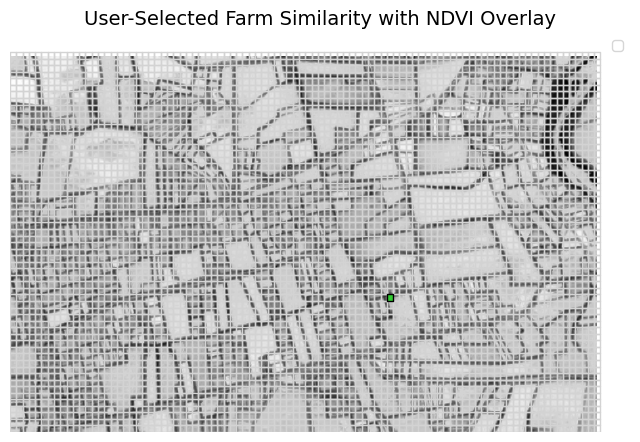

In [57]:
import rasterio
import numpy as np
from rasterio.plot import show

overlay_tiff = valid_images[len(valid_images)//2]
print("Using overlay:", overlay_tiff)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

with rasterio.open(overlay_tiff) as src:
    ndvi = src.read(1)
    bounds = src.bounds

    # Mask invalid values
    ndvi = np.where(np.isnan(ndvi), np.nan, ndvi)

    show(
        ndvi,
        ax=ax,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        cmap='Greys',
        alpha=1  # 👈 IMPORTANT: subtle overlay
    )
    
# Background grids
grid[grid["label"] == "other"].plot(
    ax=ax,
    color="none",
    edgecolor="lightgrey",
    linewidth=1
)

# Reference grid
grid[grid["label"] == "reference"].plot(
    ax=ax,
    color="limegreen",
    edgecolor="black",
    linewidth=1,
    label="Selected farm"
)

ax.set_title("User-Selected Farm Similarity with NDVI Overlay", fontsize=14)
ax.axis("off")
ax.legend()
plt.show()

In [58]:
import numpy as np

# Copy to avoid modifying original
feat_vis = feat_df.copy()

# ---------------------------------
# Identify reference row
# ---------------------------------
ref_idx = feat_vis["similarity_distance"].idxmin()

# ---------------------------------
# Compute bins EXCLUDING reference
# ---------------------------------
non_ref_distances = feat_vis.loc[
    feat_vis.index != ref_idx, "similarity_distance"
]

bins = np.percentile(
    non_ref_distances,
    [5, 15, 30]
)

# ---------------------------------
# Classification function
# ---------------------------------
def classify_similarity(i, d):
    if i == ref_idx:
        return "reference"
    elif d <= bins[0]:
        return "very_similar"
    elif d <= bins[1]:
        return "moderately_similar"
    elif d <= bins[2]:
        return "weakly_similar"
    else:
        return "other"

# ---------------------------------
# Apply classification
# ---------------------------------
feat_vis["sim_class"] = [
    classify_similarity(i, d)
    for i, d in zip(feat_vis.index, feat_vis["similarity_distance"])
]

# ---------------------------------
# Check distribution
# ---------------------------------
print(feat_vis["sim_class"].value_counts())


sim_class
other                 3815
weakly_similar         818
moderately_similar     545
very_similar           273
reference                1
Name: count, dtype: int64


In [59]:
grid = grid.merge(
    feat_vis[["grid_id", "sim_class"]],
    on="grid_id",
    how="left"
)
grid["sim_class"] = grid["sim_class"].fillna("other")

color_map = {
    "reference": "limegreen",
    "very_similar": "dodgerblue",
    "moderately_similar": "gold",
    "weakly_similar": "orangered",
    "other": "lightgrey"
}

Using NDVI overlay: NDVI_images\INDICES_2024-02-26_2024-03-11.tif


C:\Users\saina\AppData\Local\Temp\ipykernel_29520\1690311645.py:99: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower right")
C:\Users\saina\AppData\Local\Temp\ipykernel_29520\1690311645.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower right")


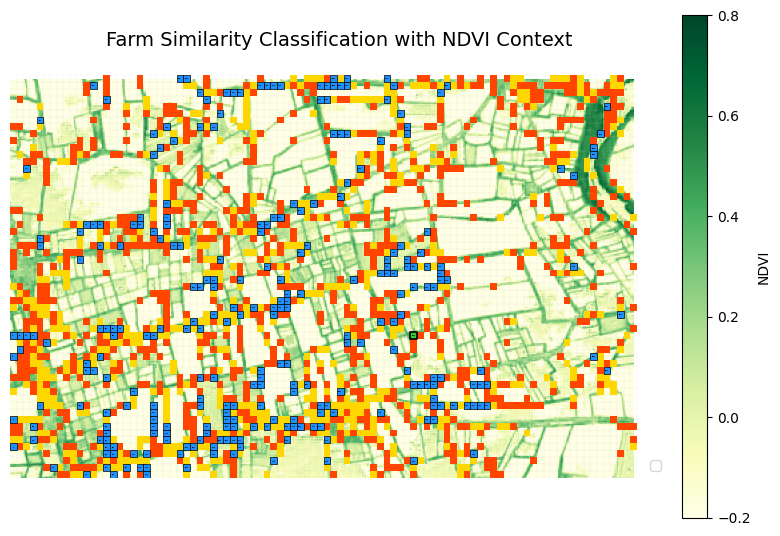

In [60]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from rasterio.plot import show

# ---------------------------------
# Choose NDVI overlay (mid-season)
# ---------------------------------
overlay_tiff = valid_images[len(valid_images)//2]
print("Using NDVI overlay:", overlay_tiff)

# ---------------------------------
# Color map for similarity classes
# ---------------------------------
color_map = {
    "reference": "limegreen",
    "very_similar": "dodgerblue",
    "moderately_similar": "gold",
    "weakly_similar": "orangered",
    "other": "lightgrey"
}

fig, ax = plt.subplots(figsize=(9, 9))

# ---------------------------------
# NDVI BACKGROUND (GeoTIFF overlay)
# ---------------------------------
with rasterio.open(overlay_tiff) as src:
    ndvi = src.read(3).astype(float)
    bounds = src.bounds

    # Mask nodata & zeros
    ndvi[ndvi == src.nodata] = np.nan
    ndvi[ndvi == 0] = np.nan

    im = ax.imshow(
        ndvi,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        cmap="YlGn",
        vmin=-0.2,
        vmax=0.8,
        alpha=1
    )

# ---------------------------------
# Plot OTHER grids (context layer)
# ---------------------------------
grid[grid["sim_class"] == "other"].plot(
    ax=ax,
    color="none",
    edgecolor="lightgrey",
    linewidth=0.2,
    alpha=0.2
)

# ---------------------------------
# Plot grids by similarity class
# ---------------------------------
for cls in ["weakly_similar", "moderately_similar", "very_similar", "reference"]:
    grid[grid["sim_class"] == cls].plot(
        ax=ax,
        color=color_map[cls],
        edgecolor="black" if cls in ["reference", "very_similar"] else "none",
        linewidth=1.2 if cls == "reference" else 0.5,
        label=cls.replace("_", " ").title()
    )

# ---------------------------------
# Label ONLY reference + very similar
# ---------------------------------
for _, row in grid[grid["sim_class"].isin(["reference", "very_similar"])].iterrows():
    x, y = row.geometry.centroid.xy
    ax.text(
        x[0], y[0],
        str(row.grid_id),
        fontsize=0,
        weight="bold",
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round,pad=0.15",
            facecolor="white",
            edgecolor="black",
            alpha=0
        )
    )

# ---------------------------------
# Colorbar (NDVI context)
# ---------------------------------
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.02)
cbar.set_label("NDVI", fontsize=10)

# ---------------------------------
# Final touches
# ---------------------------------
ax.set_title("Farm Similarity Classification with NDVI Context", fontsize=14)
ax.axis("off")
ax.legend(loc="lower right")
plt.show()


In [65]:
def classify_crop_behavior(row):
    # Dense, long-duration crops
    if (
        row["mean_ndvi"] > 0.6 and
        row["mean_evi"] > 0.45 and
        row["mean_rendvi"] > 0.4 and
        row["var_ndvi"] > 0.03
    ):
        return "Dense_Long_Duration"

    # Moderate seasonal crops
    elif (
        row["mean_ndvi"] > 0.45 and
        row["growth_rate_per_day"] > 0.001
    ):
        return "Moderate_Seasonal"

    # Perennial or very stable vegetation
    elif (
        row["mean_ndvi"] > 0.4 and
        row["var_ndvi"] < 0.02
    ):
        return "Perennial_Stable"

    # Low vegetation / fallow
    elif row["mean_ndvi"] < 0.25:
        return "Fallow_or_Sparse"

    # Everything else
    else:
        return "Short_Duration_or_Mixed"


# Apply classification
feat_vis["crop_behavior"] = feat_vis.apply(classify_crop_behavior, axis=1)

# Quick check
feat_vis["crop_behavior"].value_counts()


crop_behavior
Fallow_or_Sparse           2807
Short_Duration_or_Mixed    1613
Perennial_Stable           1019
Moderate_Seasonal            13
Name: count, dtype: int64

In [64]:
very_similar_crops = (
    feat_vis[feat_vis["sim_class"] == "very_similar"]
    ["crop_behavior"]
    .value_counts()
)
print(very_similar_crops)

crop_behavior
Short_Duration_or_Mixed    192
Perennial_Stable            80
Fallow_or_Sparse             1
Name: count, dtype: int64


Using NDVI overlay: NDVI_images\INDICES_2024-02-26_2024-03-11.tif


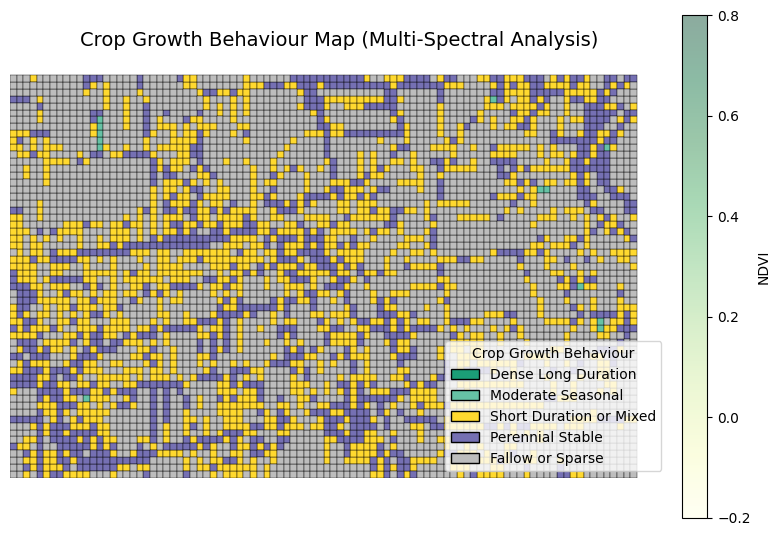

In [63]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from matplotlib.patches import Patch

# ---------------------------------
# Crop behaviour color map
# ---------------------------------
crop_color_map = {
    "Dense_Long_Duration": "#1b9e77",
    "Moderate_Seasonal": "#66c2a5",
    "Short_Duration_or_Mixed": "#ffd92f",
    "Perennial_Stable": "#7570b3",
    "Fallow_or_Sparse": "#bdbdbd"
}

# ---------------------------------
# SAFE merge (re-runnable)
# ---------------------------------
if "crop_behavior" in grid.columns:
    grid = grid.drop(columns=["crop_behavior"])

grid = grid.merge(
    feat_vis[["grid_id", "crop_behavior"]],
    on="grid_id",
    how="left"
)

# ---------------------------------
# Choose NDVI overlay (mid-season)
# ---------------------------------
overlay_tiff = valid_images[len(valid_images) // 2]
print("Using NDVI overlay:", overlay_tiff)

fig, ax = plt.subplots(figsize=(9, 9))
ax.set_aspect("equal")   # 🔑 FIX: prevents aspect ratio crash

# ---------------------------------
# NDVI BACKGROUND
# ---------------------------------
with rasterio.open(overlay_tiff) as src:
    ndvi = src.read(1).astype(float)
    bounds = src.bounds

    ndvi[ndvi == src.nodata] = np.nan
    ndvi[ndvi == 0] = np.nan

    im = ax.imshow(
        ndvi,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        cmap="YlGn",
        vmin=-0.2,
        vmax=0.8,
        alpha=0.45
    )

# ---------------------------------
# Plot crop behaviour grids (safe)
# ---------------------------------
for behavior, color in crop_color_map.items():
    subset = grid[grid["crop_behavior"] == behavior]
    if subset.empty:
        continue
    subset.plot(
        ax=ax,
        color=color,
        edgecolor="black",
        linewidth=0.3
    )

# ---------------------------------
# NDVI colorbar
# ---------------------------------

cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.02)
cbar.set_label("NDVI", fontsize=10)

# ---------------------------------
# Custom legend (fixed)
# ---------------------------------
legend_elements = [
    Patch(facecolor=crop_color_map[k], edgecolor="black",
          label=k.replace("_", " "))
    for k in crop_color_map
]

ax.legend(
    handles=legend_elements,
    title="Crop Growth Behaviour",
    loc="lower right",
    frameon=True
)

# ---------------------------------
# Final touches
# ---------------------------------
ax.set_title("Crop Growth Behaviour Map (Multi-Spectral Analysis)", fontsize=14)
ax.axis("off")
plt.show()


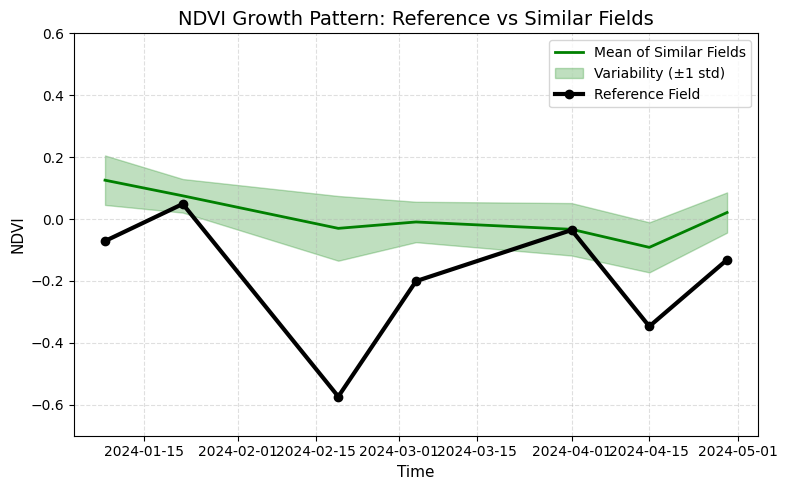

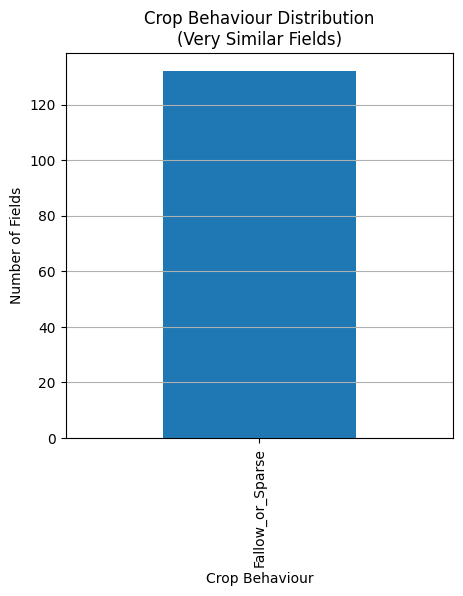

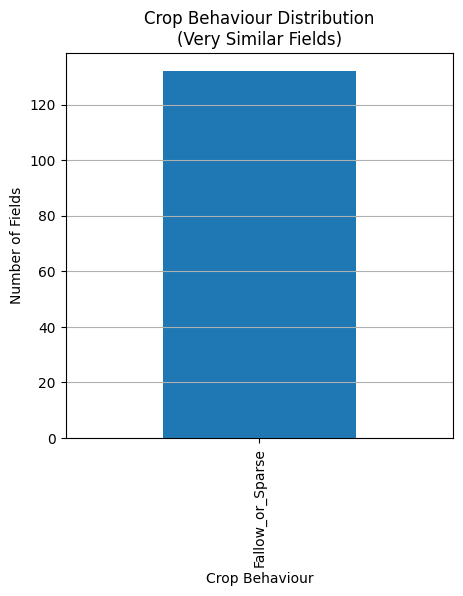

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ndvi_timeseries_clean(df, feat_vis, ref_grid_id):
    fig, ax = plt.subplots(figsize=(8, 5))

    # ---------------------------------
    # Reference field
    # ---------------------------------
    ref = df[df["grid_id"] == ref_grid_id]
    if ref.empty:
        print("❌ Reference grid has no NDVI data")
        return

    ref = ref.sort_values("mid_date")

    # ---------------------------------
    # Very similar fields
    # ---------------------------------
    similar_ids = feat_vis[
        feat_vis["sim_class"] == "very_similar"
    ]["grid_id"].tolist()

    sim_df = df[df["grid_id"].isin(similar_ids)].copy()
    sim_df = sim_df.sort_values("mid_date")

    # ---------------------------------
    # Aggregate similar fields
    # ---------------------------------
    grouped = sim_df.groupby("mid_date")["ndvi"]

    mean_ndvi = grouped.mean()
    std_ndvi = grouped.std()

    # ---------------------------------
    # Plot similar fields (summary)
    # ---------------------------------
    ax.plot(
        mean_ndvi.index,
        mean_ndvi.values,
        color="green",
        linewidth=2,
        label="Mean of Similar Fields"
    )

    ax.fill_between(
        mean_ndvi.index,
        mean_ndvi - std_ndvi,
        mean_ndvi + std_ndvi,
        color="green",
        alpha=0.25,
        label="Variability (±1 std)"
    )

    # ---------------------------------
    # Plot reference field (on top)
    # ---------------------------------
    ax.plot(
        ref["mid_date"],
        ref["ndvi"],
        color="black",
        linewidth=3,
        marker="o",
        label="Reference Field"
    )

    # ---------------------------------
    # Styling for judges
    # ---------------------------------
    ax.set_title("NDVI Growth Pattern: Reference vs Similar Fields", fontsize=14)
    ax.set_xlabel("Time", fontsize=11)
    ax.set_ylabel("NDVI", fontsize=11)

    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()
    ax.set_ylim(-0.7, 0.6)

    plt.tight_layout()
    plt.show()

def plot_feature_comparison(ref_grid_id):
    ref = feat_vis[feat_vis["grid_id"] == ref_grid_id]
    similar = feat_vis[feat_vis["sim_class"] == "very_similar"]

    features = ["mean_ndvi", "var_ndvi", "growth_rate_per_day"]

    ref_vals = ref[features].values.flatten()
    sim_vals = similar[features].mean().values

    fig, ax = plt.subplots(figsize=(6, 4))

    x = range(len(features))
    ax.bar(x, ref_vals, width=0.4, label="Reference", align="center")
    ax.bar(
        [i + 0.4 for i in x],
        sim_vals,
        width=0.4,
        label="Similar Fields"
    )

    ax.set_xticks([i + 0.2 for i in x])
    ax.set_xticklabels(features, rotation=20)
    ax.set_title("Feature Comparison")
    ax.legend()

    return fig
    
def plot_crop_behavior_distribution():
    counts = (
        feat_vis[feat_vis["sim_class"] == "very_similar"]
        ["crop_behavior"]
        .value_counts()
    )

    fig, ax = plt.subplots(figsize=(5, 5))
    counts.plot(kind="bar", ax=ax)

    ax.set_title("Crop Behaviour Distribution\n(Very Similar Fields)")
    ax.set_ylabel("Number of Fields")
    ax.set_xlabel("Crop Behaviour")
    ax.grid(axis="y")
    return fig
    
plot_ndvi_timeseries_clean(df, feat_vis, ref_grid_id)
plot_crop_behavior_distribution()